# IMPORTING THE LIBRARIES

In [1]:
# IMPORTING TORCH
import torch
from torch import nn
import numpy as np

# IMPORTING THE VISION LIBRAIRES
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# IMPORTING VISUALIZTION LIBRAIRES
import matplotlib.pyplot as plt

# GETTING THE DATASET

In [2]:
# train dataset
train_dataset = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
    )

# testing dataset
test_dataset = datasets.FashionMNIST(
    root="data",
    download=True,
    train=False,
    transform=ToTensor(),
    target_transform=None,
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.7MB/s]


In [3]:
# OVERVIEW OF THE TRAIN DATASET
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
# OVERVIEW OF THE TEST DATASET
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# labels used in it
classes = train_dataset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
# TRAGET VALUE FOR THE CLASSES
classes_idx = train_dataset.class_to_idx
classes_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
# SHAPE OF THE IMAGES
image,target = train_dataset[3]
print(f"The shape of the images is {image.shape}")
print(f"the label of that image is {target}")

The shape of the images is torch.Size([1, 28, 28])
the label of that image is 3


# VISUALIZING THE DATA

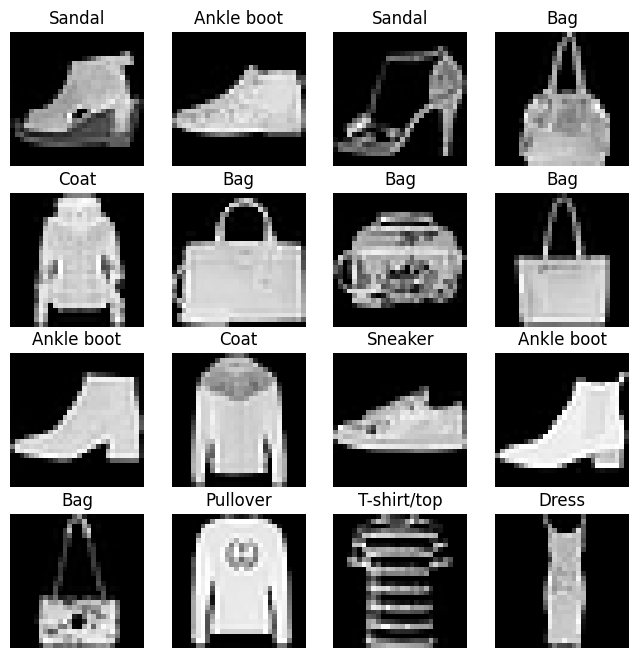

In [8]:
fig = plt.figure(figsize=(8,8))
row,col = 4,4
for i in range(1,row*col+1):
    random_int = torch.randint(0,len(train_dataset),size=[1]).item()
    img,label = train_dataset[random_int]
    fig.add_subplot(row,col,i)
    plt.imshow(img.squeeze(),
               cmap="gray"
               )
    plt.title(classes[label])
    plt.axis(False)

# DATA LOADER

In [9]:
from torch.utils.data import DataLoader

In [10]:
# CREATING A DATALOADER FOR TRAINING DATASET
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
    )
# CREATING A DATALOADER FOR THE TESTING DATASET
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
    )

In [11]:
# STORING DATASET IN BATCHES
train_dataset_batches,train_dataset_labels = next(iter(train_dataloader))

test_dataset_batches,test_dataset_labels = next(iter(test_dataloader))

In [12]:
print(f"No of batches in train dataset batches {len(train_dataloader)}")
print(f"No of batches in the test dataset batches {len(test_dataloader)}")

No of batches in train dataset batches 1875
No of batches in the test dataset batches 313


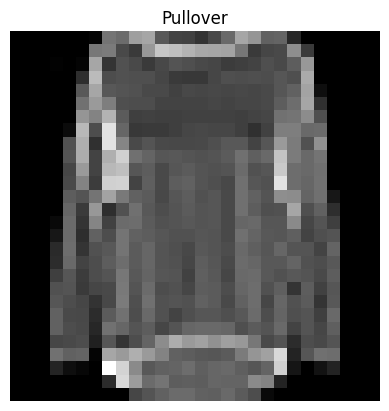

In [13]:
# VISUALIZING THE BATCHES
random_int = torch.randint(1,len(train_dataset_batches),size=[1]).item()
img,label = train_dataset_batches[random_int],train_dataset_labels[random_int]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(classes[label])
plt.axis(False)
print()

# MODELLING

## MODEL ARCHITECTURE

In [14]:
from torch.types import Tensor
class FashionMNISTModel(nn.Module):
    """
    This is a baseline architecture which takes the arguments

    Arguments
    input_units: the no of  units should be in the input layers
    ouput_units: the no of units should be in output layer
    hidden_units: the no of units in hidden layer
    """
    def __init__(self,input_units:int,output_units:int,hidden_units:int) -> list[torch.tensor]:
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_units)
        )

    def forward(self,X:list[torch.tensor]):
        return self.layer_stack(X)

In [15]:
# instance of the model
model_01 = FashionMNISTModel(input_units=784,output_units=len(classes),hidden_units=10)

In [16]:
model_01

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
pred = model_01(train_dataset_batches[0])

In [18]:
pred

tensor([[-1.6283e-01, -3.4374e-01,  2.2034e-01,  2.8671e-01,  2.1556e-01,
          5.8218e-01,  4.0887e-01,  3.4928e-01, -6.4561e-03,  1.9132e-04]],
       grad_fn=<AddmmBackward0>)

## LOSS FUNCTION AND OPTIMIZER

In [19]:
# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# OPTIMIZER
optimizer = torch.optim.SGD(params=model_01.parameters(),lr=0.1)

## EVALUATION METRICS

In [20]:
# USING HELPER FUNCTION
import requests,pathlib

if pathlib.Path('helper_functions.py').is_file():
    print("already downloaded")
else:
    response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py','wb') as file:
        file.write(response.content)
    print("Downloaded successfully")


Downloaded successfully


## MEASURING HOW MUCH TIME THE MODEL TAKES FOR TRAINING

In [21]:
from timeit import default_timer as Timer

In [22]:
def print_train_time(start_time:int,end_time:int,device:torch.device)->int:
    """return the total time taken"""
    total_time = end_time - start_time
    print(f"train time taken on {device} is {total_time:.4f} seconds")
    return total_time

## TRAINING THE MODEL

In [23]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

In [24]:
# RANDOM SEED
torch.cuda.manual_seed(42)

# TRAIN TIMER
train_start_time_cpu = Timer()

# NO OF EPOCHS:
epochs = 3

# TRAINING LOOP
for epoch in tqdm(range(epochs)):

    # TRAINING MODE
    model_01.train()

    # TRAIN_LOSS
    train_loss = 0

    # TRAIN_ACCURACY
    train_accuracy = 0

    # ITERTATING THROUGHT BATCHES
    for batches,(X_train,y_train) in enumerate(train_dataloader):

        # FORWARD PASS
        y_pred_train = model_01(X_train)

        # TRAIN_LOSS
        loss = loss_fn(y_pred_train,y_train)
        train_loss += loss

        # OPTIMIZER ZERO GRAD
        optimizer.zero_grad()

        # LOSS BACKWARD
        loss.backward()

        # OPTIMIZER STEP
        optimizer.step()

        # TRAIN ACCURACY
        train_accuracy += accuracy_fn(y_train,y_pred_train.argmax(dim=1))

        if batches%400 == 0:
            print(f"training samples trained = {batches*len(X_train)}/{len(train_dataloader.dataset)}")

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)


    # TESTING LOOP

    test_loss = 0
    test_accuraccy = 0

    model_01.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:

            # TEST PREDICTION
            y_pred_test = model_01(X_test)

            # TEST_LOSS
            test_loss += loss_fn(y_pred_test,y_test)

            # TEST ACCURACY
            test_accuraccy += accuracy_fn(y_test,y_pred_test.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_accuraccy /= len(test_dataloader)

        print(f"Epoch: {epoch}| train_loss: {train_loss:.2f},train accuracy: {train_accuracy:.2f} test_loss: {test_loss:.2f}, test_accuracy: {test_accuraccy:.2f}")

train_end_time_cpu = Timer()

total_time_model_01 = print_train_time(start_time=train_start_time_cpu,end_time=train_end_time_cpu,device=str(next(model_01.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

training samples trained = 0/60000
training samples trained = 12800/60000
training samples trained = 25600/60000
training samples trained = 38400/60000
training samples trained = 51200/60000
Epoch: 0| train_loss: 0.58,train accuracy: 79.47 test_loss: 0.53, test_accuracy: 81.31
training samples trained = 0/60000
training samples trained = 12800/60000
training samples trained = 25600/60000
training samples trained = 38400/60000
training samples trained = 51200/60000
Epoch: 1| train_loss: 0.48,train accuracy: 83.22 test_loss: 0.55, test_accuracy: 80.46
training samples trained = 0/60000
training samples trained = 12800/60000
training samples trained = 25600/60000
training samples trained = 38400/60000
training samples trained = 51200/60000
Epoch: 2| train_loss: 0.45,train accuracy: 84.09 test_loss: 0.47, test_accuracy: 83.56
train time taken on cpu is 29.6441 seconds


## INFERENCE ON THE MODEL

In [25]:
def evaluate_model(
        model:torch.nn.Module,
        data_loader:torch.utils.data.dataloader,
        loss_funtion:torch.nn.Module,
        device:torch.device,
    ):
    """
    It returns the accuracy and loss of the model
    Params:
    model: instance of the model
    data_loader: dataloader for inference
    loss_function: the loss function to calculate loss
    device: the device it should run on

    """

    losses,accuracies = 0,0

    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_funtion(y_pred,y)
            acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
            losses += loss
            accuracies += acc


    losses = losses/len(data_loader)
    accuracies = accuracies/len(data_loader)


    result = {
        'Model_name':f"{model.__class__.__name__}",
        'Loss':f"{losses}",
        'accuracy':f"{accuracies:.4f}"
    }

    return result

model_01_result = evaluate_model(model_01,test_dataloader,loss_fn,"cpu")
model_01_result

{'Model_name': 'FashionMNISTModel',
 'Loss': '0.4678780436515808',
 'accuracy': '83.5563'}

# MODELLING (GPU)

## DEVICCE AGNOSTIC CODE

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## MODEL ARCITECTURE

In [27]:
class FashionMNISTv2(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_units:int):

        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_units ),

        )

    def forward(self, X:torch.Tensor):
        return self.linear_stack(X)

In [28]:
# CREATING A INSTANCE OF THE MODEL
model_02 = FashionMNISTv2(input_shape=784,
                        hidden_units=10,
                        output_units=len(classes)).to(device)

In [29]:
model_02.state_dict()

OrderedDict([('linear_stack.1.weight',
              tensor([[ 0.0151, -0.0317, -0.0035,  ..., -0.0014, -0.0273,  0.0319],
                      [-0.0010,  0.0231, -0.0056,  ...,  0.0254, -0.0185, -0.0127],
                      [-0.0088,  0.0278, -0.0341,  ..., -0.0177, -0.0159, -0.0242],
                      ...,
                      [ 0.0209, -0.0274,  0.0013,  ..., -0.0064, -0.0106, -0.0038],
                      [ 0.0038, -0.0265,  0.0039,  ..., -0.0064, -0.0271,  0.0207],
                      [-0.0070,  0.0233, -0.0197,  ...,  0.0063, -0.0232,  0.0253]])),
             ('linear_stack.1.bias',
              tensor([-0.0259, -0.0063, -0.0324, -0.0140, -0.0244, -0.0017, -0.0027,  0.0085,
                       0.0197,  0.0121])),
             ('linear_stack.3.weight',
              tensor([[ 0.1495, -0.1735,  0.2757,  0.0183,  0.2836,  0.0506, -0.3025, -0.3039,
                       -0.1821, -0.1830],
                      [ 0.0296, -0.2732, -0.2950, -0.1149,  0.1233,  0.1112, 

## LOSS FUNCTION AND OPTIMIZER

In [30]:
# loss function
loss_fn_02 = nn.CrossEntropyLoss()

# optimizer
optim_02 = torch.optim.SGD(params=model_02.parameters(),lr = 0.1)

In [31]:
def train_step(model:nn.Module,
               data_loader:torch.utils.data.dataloader,
               loss_function:nn.Module,
               optimizers:torch.optim.Optimizer,
               device = device):
    """
    Trains the model using the dataloader

    params:
    model (nn.Module):
    dataloder (torch.utils.data.dataloader):
    optimizer (torch.optim.Optimizer):
    device (torch.device)
    """

    train_loss,train_acc = 0,0
    loss = 0

    # training mode
    model.train()

    for X,y in data_loader:

        # MOVING X AND y to device
        X,y = X.to(device),y.to(device)

        # INPUT DATA (FORWARD PASS)
        y_pred = model(X)

        # CALCULATING THE LOSS
        loss = loss_function(y_pred,y)
        train_loss += loss

        # ACCURACY
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))

        # OPTIMIZER ZERO GRAD
        optimizers.zero_grad()

        # BACK PROPAGATION
        loss.backward()

        # OPTIMIZER STEP
        optimizers.step()

    train_loss /=  len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}% ")

In [32]:
def test_step(model:nn.Module,
              data_loader:torch.utils.data.dataloader,
              loss_function:nn.Module,
              device:torch.device = device):

    """
    testing of the model using dataloader

    params:

    model (nn.Module):
    data_loader (torch.utils.data.dataloader):
    loss_function (nn.Module):
    optim (torch.optim.Optimizer):
    device (torch.device)

    """

    test_loss,test_acc = 0,0
    loss = 0

    # EVALUATION MODE
    model.eval()
    with torch.inference_mode():

        for X,y in data_loader:

            # MOVING DATA TO THE TARGET DEVICE
            X,y = X.to(device),y.to(device)

            # FORWARD PASS
            y_pred = model(X)

            # LOSS
            loss = loss_function(y_pred,y)
            test_loss += loss
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))


        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

## TRAINING THE MODEL

In [33]:
epochs = 3

train_time_start_on_gpu = Timer()

for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch}")

    # TRAINING THE MODEL
    train_step(model_02,train_dataloader,loss_fn_02,optim_02)

    # EVALUATING THE MODEL
    test_step(model_02,test_dataloader,loss_fn_02)

train_time_end_on_gpu = Timer()

total_time_on_gpu = train_time_end_on_gpu - train_time_start_on_gpu
print(f"The total time taken is : {total_time_on_gpu:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.6326 | Accuracy: 77.38% 
Test Loss: 0.5146 | Test Accuracy: 81.86%
Epoch: 1
Train Loss: 0.4753 | Accuracy: 83.06% 
Test Loss: 0.4658 | Test Accuracy: 83.64%
Epoch: 2
Train Loss: 0.4421 | Accuracy: 84.16% 
Test Loss: 0.4573 | Test Accuracy: 83.87%
The total time taken is : 29.9728


In [34]:
model_02

FashionMNISTv2(
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

## EVALUATING THE MODEL

In [35]:
model_02_result = evaluate_model(model_02,test_dataloader,loss_fn_02,device)

In [36]:
model_02_result

{'Model_name': 'FashionMNISTv2',
 'Loss': '0.45725470781326294',
 'accuracy': '83.8658'}

In [37]:
model_01_result

{'Model_name': 'FashionMNISTModel',
 'Loss': '0.4678780436515808',
 'accuracy': '83.5563'}

# CONVOLUTINAL NEURAL NETWORK


## MODEL ARCHITECTURE

In [38]:
class FashionMNISTv3(nn.Module):
    """
    Creates a tinyVGG model used in the CNN website
    """
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(

            nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1
                ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2,
            )
            )

        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(
                        kernel_size = 2,
                    ),
        )

        self.classifier_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 490,
                      out_features = output_shape)
        )

    def forward(self,x:torch.tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier_block(x)
        # print(x.shape)
        return x



In [39]:
# INITIATING A MODEL
model_03 = FashionMNISTv3(input_shape= 1,
                          hidden_units = 10,
                          output_shape=len(classes)).to(device)

In [40]:
model_03

FashionMNISTv3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [41]:
# LEARNING ABOUT CONV2D
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride =1,
                       padding=2,
                       )
conv_layer

Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))

In [42]:
test_image = torch.rand(size=[3,64,64])
test_image.shape

torch.Size([3, 64, 64])

In [43]:
result = conv_layer(test_image)
result.shape

torch.Size([10, 66, 66])

In [44]:
# LEARNING ABOUT MAXPOOL LAYER
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_layer_result = max_pool_layer(test_image)
max_pool_layer_result.shape

torch.Size([3, 32, 32])

In [45]:
torch.manual_seed(17)
random_tensor = torch.rand(size=(1,1,2,2))
random_tensor

tensor([[[[0.4342, 0.5351],
          [0.8302, 0.1239]]]])

In [46]:
random_tensor.shape

torch.Size([1, 1, 2, 2])

In [47]:
max_pool_result = max_pool_layer(random_tensor)
print(f"the result after applying the max pooling {max_pool_result}")
print(f"the shape after max pooling is {max_pool_result.shape}")

the result after applying the max pooling tensor([[[[0.8302]]]])
the shape after max pooling is torch.Size([1, 1, 1, 1])


In [48]:
# CHECKING THE DIMENSION A THE TINY VGG
model_testing_image = torch.rand(size=(1,28,28))
print(f"the model testing image shape: {model_testing_image.shape}")

the model testing image shape: torch.Size([1, 28, 28])


In [49]:
model_03(model_testing_image.unsqueeze(0).to(device))

tensor([[ 0.1075, -0.0315, -0.0748, -0.0137, -0.0140,  0.0334,  0.0715, -0.0051,
          0.0208,  0.0320]], grad_fn=<AddmmBackward0>)

## LOSS FUNCTION AND OPTIMIZER

In [50]:
# loss function
loss_fn_03 = nn.CrossEntropyLoss()

# optimizer
optim_03 = torch.optim.SGD(model_03.parameters(),lr=0.1)

## TRAINING THE MODEL

In [51]:
epochs = 3


start_time_model_03 = Timer()

for epoch in tqdm(range(epochs)):

    # epoch
    print(f"Epoch: {epoch}")

    # training data
    train_step(model_03,train_dataloader,loss_fn_03,optim_03,device)

    # testing data
    test_step(model_03,test_dataloader,loss_fn_03,device)

end_time_model_03 = Timer()

total_time_model_03 = print_train_time(start_time_model_03,end_time_model_03,device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.5800 | Accuracy: 79.13% 
Test Loss: 0.3917 | Test Accuracy: 85.81%
Epoch: 1
Train Loss: 0.3610 | Accuracy: 87.17% 
Test Loss: 0.3425 | Test Accuracy: 87.99%
Epoch: 2
Train Loss: 0.3255 | Accuracy: 88.31% 
Test Loss: 0.3274 | Test Accuracy: 88.40%
train time taken on cpu is 152.5924 seconds


## EVALUATING THE MODEL

In [52]:
model_03_result = evaluate_model(model_03,test_dataloader,loss_fn_03,device)
model_03_result

{'Model_name': 'FashionMNISTv3',
 'Loss': '0.3273506462574005',
 'accuracy': '88.3986'}

In [53]:
def prediction_probabilities(model:torch.nn.Module,
                             data:list,
                             device:torch.device = device)->torch.tensor:
    """
    Calculates the prediction probabilites of the model

    params:
    model (torch.nn.module)
    data (list)
    device (torch.device)

    returns:
    prediction probabilities list[list]
    """
    pred_probabilities = []

    model.to(device)

    model.eval()
    with torch.inference_mode():
        for img in data:
            sample = torch.unsqueeze(img,dim=0).to(device)
            y_logits = model(sample)
            y_probs = torch.softmax(y_logits.squeeze(),dim=0)
            pred_probabilities.append(y_probs.cpu())


    return torch.stack(pred_probabilities)

In [54]:
# RANDOM NUMBERS
import random

test_image,test_label  = [],[]

for image,label in random.sample(list(test_dataset),k=9):
    test_label.append(label)
    test_image.append(image)

y_probs = prediction_probabilities(model_03,test_image,device)

In [55]:
y_label = y_probs.argmax(dim=1)
y_label

tensor([9, 4, 1, 9, 0, 1, 3, 3, 7])

In [56]:
test_label

[9, 4, 1, 9, 0, 1, 3, 3, 7]

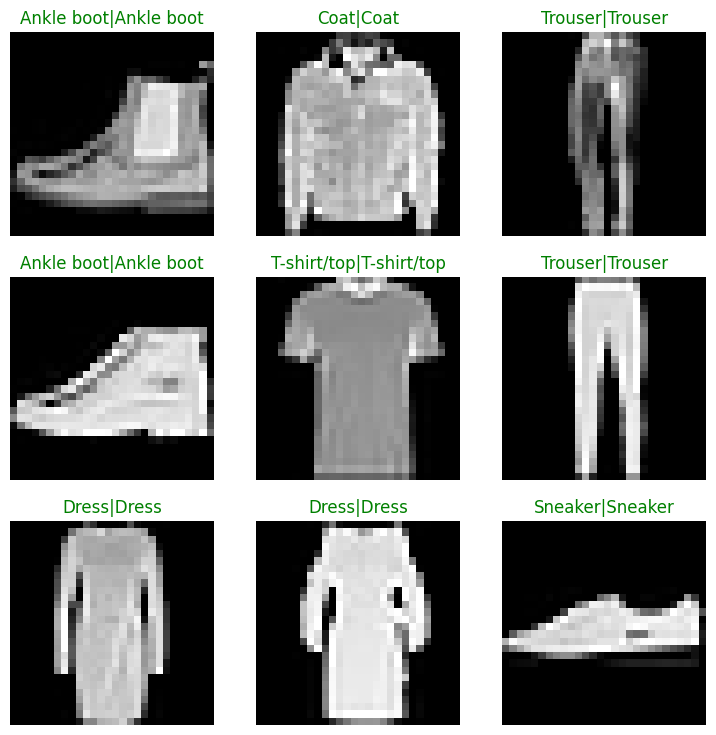

In [57]:
# Plotting the predictions

plt.figure(figsize=(9,9))
n_rows = 3
n_cols = 3

for i,img in enumerate(test_image):
    # CREATING A SUBPLOT
    plt.subplot(n_rows,n_cols,i+1)

    # PLOTTING THE IMAGES
    plt.imshow(img.squeeze(),cmap="gray")

    # PREDICTION LABEL
    pred_label = y_label[i]

    # TRUTH LABEL
    truth_label = classes[test_label[i]]

    title = f"{classes[pred_label]}|{truth_label}"

    if pred_label == test_label[i]: # Compare pred_label with the original integer label
        plt.title(title,c='g')
    else:
        plt.title(title,c='r')

    plt.axis(False)

# EXPERIMENTATIONS

In [58]:
import pandas as pd

In [59]:
results = pd.DataFrame(model_01_result,
                       model_02_result,
                       model_03_result)

In [60]:
results['training_time'] = [total_time_model_01,total_time_on_gpu,total_time_model_03]
results.reset_index(inplace=True)
results.drop('index',axis=1,inplace=True)

In [61]:
results

,Model_name,Loss,accuracy,training_time
0,FashionMNISTModel,0.4678780436515808,83.5563,29.644059
1,FashionMNISTModel,0.4678780436515808,83.5563,29.972768
2,FashionMNISTModel,0.4678780436515808,83.5563,152.592426


# VISUALIZATION OF PERFORMANCE

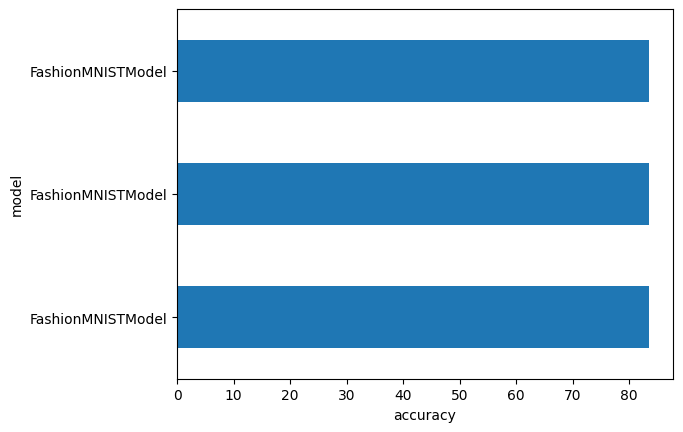

In [62]:
results.set_index('Model_name')['accuracy'].astype(float).plot(kind="barh")
plt.xlabel('accuracy')
plt.ylabel('model')
plt.show()

# PLOTTING CONFUSION MATRIX


In [63]:
try:
    import torchmetrics,mlxtend
    print(f"Version of torchmetrics: {torchmetrics.__version__}")
    print(f"Version of mlxtend: {mlxtend.__version__}")
except:
    ! pip install -q torchmetrics -U mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.4 MB/s eta 0:00:00


In [64]:
# INFERNCE ON THE TEST DATASET
y_preds = []

model_03.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader,desc="Inference on the test dataset"):

        # moving to the GPU
        X,y = X.to(device),y.to(device)

        # making prediction
        y_logits = model_03(X)

        # logits -> probabilites -> label
        y_pred = torch.softmax(y_logits.squeeze(),dim=0).argmax(dim=1)

        # appending the predictions
        y_preds.append(y_pred.cpu())


y_pred_tensor = torch.cat(y_preds)

Inference on the test dataset:   0%|          | 0/313 [00:00<?, ?it/s]

In [65]:
y_pred_tensor.shape

torch.Size([10000])

In [66]:
y_pred_tensor

tensor([9, 2, 1,  ..., 8, 3, 4])

In [67]:
import torchmetrics,mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(task="multiclass",num_classes=len(classes))
confmat_tensor = confmat(y_pred_tensor,test_dataset.targets)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

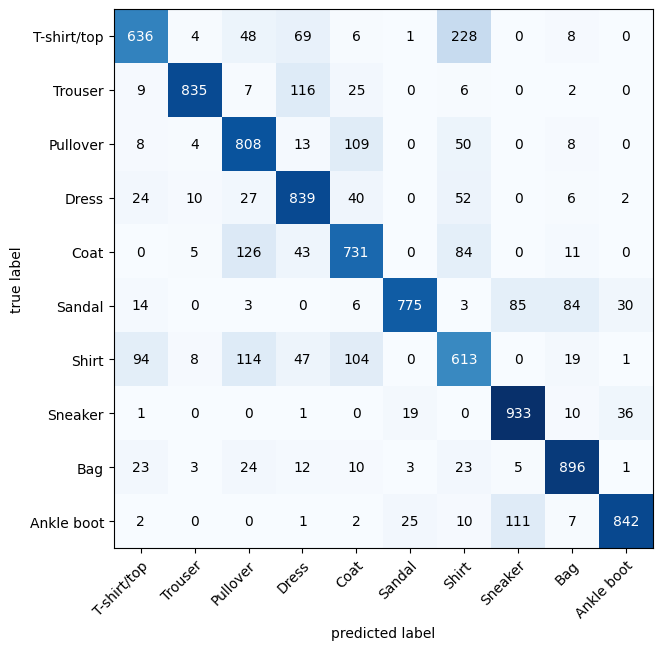

In [68]:
plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                      figsize = (10,7),
                      class_names = classes
                      )

# SAVING THE BEST PERFORMING MODEL

In [69]:
from pathlib import Path

model_path = Path('model')
model_path.mkdir(parents=True,exist_ok=True)
MODEL_PATH = "TinyVGG_Computer_vison_model.pth"
MODEL_SAVE_PATH = model_path/MODEL_PATH


# saving the model
torch.save(model_03.state_dict(),f=MODEL_SAVE_PATH)

In [70]:
torch.manual_seed(17)
# CREATING THE NEW INSTANCE
loaded_model = FashionMNISTv3(input_shape= 1,
                              hidden_units = 10,
                              output_shape=len(classes))


# LOADING THE MODEL STATE DICT
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# MOVING THE MODEL TO TARGET DEVICE
loaded_model.to(device)

loaded_model

FashionMNISTv3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [71]:
# EVALUATING THE LOADED MODEL
loaded_model_result = evaluate_model(loaded_model,test_dataloader,loss_fn_03,device)
loaded_model_result

{'Model_name': 'FashionMNISTv3',
 'Loss': '0.3273506462574005',
 'accuracy': '88.3986'}

In [72]:
model_03_result

{'Model_name': 'FashionMNISTv3',
 'Loss': '0.3273506462574005',
 'accuracy': '88.3986'}